# Домашнее задание 5. Рекуррентные нейронные сети

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from keras.callbacks import EarlyStopping
from keras.layers import Conv1D

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

## Задание
1. Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). 

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

## План решения

[0. Загрузка и обработка данных](#section_0)

[1. Подготовка данных](#section_1)

[2. Построение модели SimpleRNN (RNN)](#section_2)

[3. Построение модели Long Short Term Memory (LSTM)](#section_3)

[4. Построение модели Gated Recurrent Unit (GRU)](#section_4)
    
[5. Сводная таблица метрик и выводы](#section_5)

Используем рекуррентные нейронные сети для моделирования последовательности данных

## 0. Загрузка  и обработка данных<a id='section_0'></a>

Загрузка датасета

In [2]:
df = pd.read_csv('airline-passengers.csv')
df = df.rename(columns={'Month': 'Date'})
df.head()

,Date,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Создание новых признаков

In [3]:
#излекаем месяц
month = [i[5:] for i in df['Date'].values]

#излекаем год
year = [i[:-3] for i in df['Date'].values]

df['Year'] = year
df['Month'] = month

df = df.drop(['Date'], axis = 1) 
df = df.astype({"Year": 'int64', "Month": 'int64'})

#извлекаем квартал
quarter = (df['Month'] + 2)//3

#определяем олимпийский год
olimpic_year = round(df['Year'] % 4 == 0)

df['Quarter'] = quarter
df['Olimpic_year'] = olimpic_year
df['Olimpic_year'] = df['Olimpic_year'].astype(np.int8)

#определяем число дней в месяце
df['Days_in_month'] = np.where(df['Month'].isin([1, 3, 5, 7, 8, 10, 12]), 31, 30)
df.loc[(df['Month'].isin([2])), 'Days_in_month'] = 28
df.loc[(df['Month'].isin([2])) & (df['Year'].isin([1952, 1956, 1960])), 'Days_in_month']= 29

#количество крупных авиакатастроф в году по данным Википедии
df['Air_disaster'] = [1] * 12 + [3] * 12 + [0] * 12 + [0]*12 + [3]*12 + [2]*12 + [0]*12 + [1]*12 + [2]*12 + [3]*12 + [4]*12 + [3]*12

df

,Passengers,Year,Month,Quarter,Olimpic_year,Days_in_month,Air_disaster
0,112,1949,1,1,0,31,1
1,118,1949,2,1,0,28,1
2,132,1949,3,1,0,31,1
3,129,1949,4,2,0,30,1
4,121,1949,5,2,0,31,1
...,...,...,...,...,...,...,...
139,606,1960,8,3,1,31,3
140,508,1960,9,3,1,30,3
141,461,1960,10,4,1,31,3
142,390,1960,11,4,1,30,3


Обзор датасета

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Passengers     144 non-null    int64
 1   Year           144 non-null    int64
 2   Month          144 non-null    int64
 3   Quarter        144 non-null    int64
 4   Olimpic_year   144 non-null    int8 
 5   Days_in_month  144 non-null    int32
 6   Air_disaster   144 non-null    int64
dtypes: int32(1), int64(5), int8(1)
memory usage: 6.5 KB


In [5]:
df.describe()

,Passengers,Year,Month,Quarter,Olimpic_year,Days_in_month,Air_disaster
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,280.298611,1954.500000,6.500000,2.500000,0.250000,30.437500,1.833333
std,119.966317,3.464102,3.464102,1.121936,0.434524,0.816943,1.348400
min,104.000000,1949.000000,1.000000,1.000000,0.000000,28.000000,0.000000
25%,180.000000,1951.750000,3.750000,1.750000,0.000000,30.000000,0.750000
50%,265.500000,1954.500000,6.500000,2.500000,0.000000,31.000000,2.000000
75%,360.500000,1957.250000,9.250000,3.250000,0.250000,31.000000,3.000000
max,622.000000,1960.000000,12.000000,4.000000,1.000000,31.000000,4.000000


Обзор распределения целевой переменной

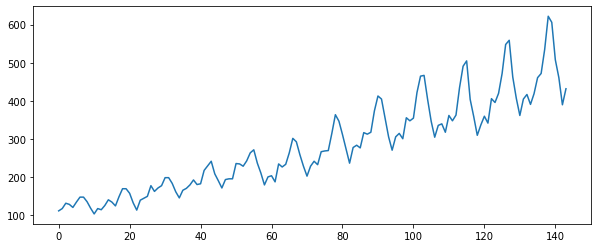

In [6]:
df['Passengers'].plot(figsize=(10, 4))
plt.show()

## 1. Подготовка данных<a id='section_1'></a>

Разбивка выборки на обучение и тест

In [7]:
train_size = 100

# список признаков, по которым будем учить
features = ['Passengers', 'Year', 'Month', 'Quarter', 'Olimpic_year', 'Days_in_month', 'Air_disaster']

# отступ теста от тренировки
bias = 5

# делим
train_data = df.iloc[:train_size][features]
val_data = df.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 7), (39, 7))

Создание данных для обучения

In [8]:
features = train_data.columns[1:]
target = train_data.columns[0]

features, target

(Index(['Year', 'Month', 'Quarter', 'Olimpic_year', 'Days_in_month',
        'Air_disaster'],
       dtype='object'),
 'Passengers')

In [9]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,Year,Month,Quarter,Olimpic_year,Days_in_month,Air_disaster
0,112,-1.525724,-1.534863,-1.287935,-0.561951,0.691457,-0.236508
1,118,-1.525724,-1.247435,-1.287935,-0.561951,-2.885044,-0.236508
2,132,-1.525724,-0.960008,-1.287935,-0.561951,0.691457,-0.236508
3,129,-1.525724,-0.672580,-0.399704,-0.561951,-0.500710,-0.236508
4,121,-1.525724,-0.385153,-0.399704,-0.561951,0.691457,-0.236508


Формирование параметров для генерации выборки

In [10]:
# длина истории
x_len = 5

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 10
epochs = 100

In [11]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = df.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = df.iloc[label_start:][target].values

6 106
33 111


In [12]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 6), (100,), (33, 6), (33,))

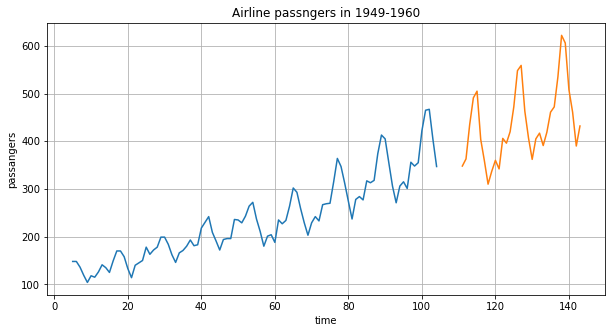

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(df.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(df.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('time')
plt.ylabel('passangers')
plt.title('Airline passаngers in 1949-1960')
plt.show()

In [14]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [15]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (10, 5, 6)
tf.Tensor(
[[-1.52572369 -1.24743549 -1.28793522 -0.56195149 -2.88504406 -0.23650808]
 [-1.52572369 -0.96000796 -1.28793522 -0.56195149  0.69145684 -0.23650808]
 [-1.52572369 -0.67258043 -0.39970403 -0.56195149 -0.50071013 -0.23650808]
 [-1.52572369 -0.38515289 -0.39970403 -0.56195149  0.69145684 -0.23650808]
 [-1.52572369 -0.09772536 -0.39970403 -0.56195149 -0.50071013 -0.23650808]], shape=(5, 6), dtype=float64)
Target shape: (10,)
tf.Tensor(148, shape=(), dtype=int64)


## 2. Построение модели SimpleRNN (RNN)<a id='section_2'></a>

In [17]:
early_stop = EarlyStopping(monitor='val_mae', 
                           patience=5,
                           restore_best_weights=True)

In [64]:
tf.random.set_seed(8)

model_1 = Sequential()
model_1.add(SimpleRNN(256, 
                      input_shape=(inputs.shape[1], inputs.shape[2]),
                      return_sequences=True))

model_1.add(Flatten())

#полносвязный слой
model_1.add(Dense(128, activation='linear'))
model_1.add(Dense(64, activation='linear'))
model_1.add(Dense(32, activation='linear'))
model_1.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001) 

model_1.compile(loss='mse', optimizer=opt, metrics=['mae'])
model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 5, 256)            67328     
                                                                 
 flatten_12 (Flatten)        (None, 1280)              0         
                                                                 
 dense_47 (Dense)            (None, 128)               163968    
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 241,665
Trainable params: 241,665
Non-t

In [65]:
%%time

history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                        verbose=1,
                    callbacks=[early_stop]
                   )

#метрики модели
test_loss, test_metric = model_1.evaluate(dataset_val)
print(f"Test loss {test_loss}, Test mae {test_metric}")

Epoch 1/100
10/10 [==============================] - 1s 25ms/step - loss: 62236.2695 - mae: 234.2938 - val_loss: 211946.2812 - val_mae: 453.0166
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 56654.9844 - mae: 223.6994 - val_loss: 198939.0469 - val_mae: 438.6568
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 56612.0195 - mae: 225.5161 - val_loss: 196180.8906 - val_mae: 435.4968
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 55643.7617 - mae: 224.2097 - val_loss: 193502.5938 - val_mae: 432.1017
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 51350.2539 - mae: 216.0210 - val_loss: 176461.3906 - val_mae: 409.8289
Epoch 6/100
10/10 [==============================] - 0s 11ms/step - loss: 28277.0781 - mae: 155.6671 - val_loss: 38835.3867 - val_mae: 178.0350
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 9644.1318 - mae: 79.7141 - val_loss: 25361.0000 - val_mae

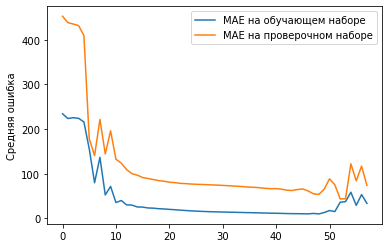

In [20]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [21]:
pred = model_1.predict(dataset_train).flatten()
pred_val = model_1.predict(dataset_val).flatten()

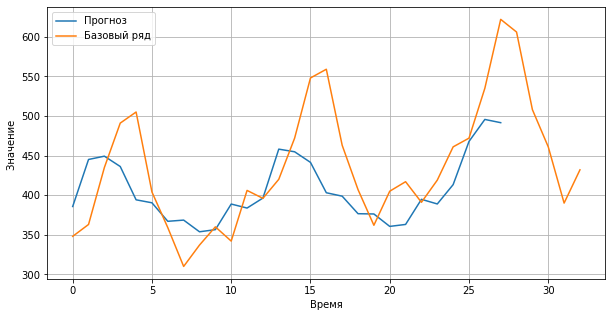

In [22]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

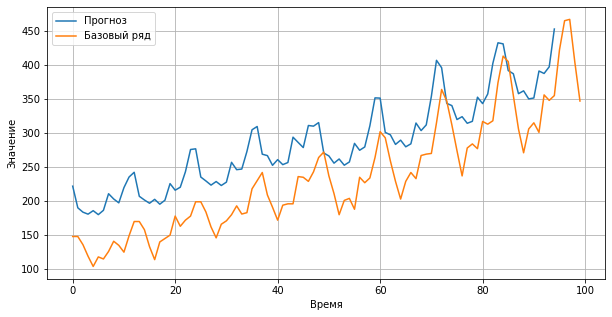

In [23]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [47]:
#датафрейм с метриками
RNN_result = pd.DataFrame({'Model': ['RNN'], 
                           'Train mae': [history_1.history['mae'][-6]], 
                           'Test mae': [history_1.history['val_mae'][-6]]})

RNN_result

,Model,Train mae,Test mae
0,RNN,36.032673,43.343803


## 3. Построение модели Long Short Term Memory (LSTM)<a id='section_3'></a>

In [40]:
tf.random.set_seed(8)

model_2 = Sequential()

#рекуррентный слой
model_2.add(LSTM(128,
               input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(Dropout(0.25))

#сверточный слой
model_2.add(Conv1D(256, 3, activation='linear'))

model_2.add(Flatten())

#полносвязный слой
model_2.add(Dense(128, activation='linear'))
model_2.add(Dense(64, activation='linear'))
model_2.add(Dense(32, activation='linear'))
model_2.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001) 

model_2.compile(loss='mse', optimizer=opt, metrics=['mae'])
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 128)            69120     
                                                                 
 dropout_3 (Dropout)         (None, 5, 128)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 3, 256)            98560     
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               98432     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)               

In [41]:
%%time

history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop]
                   )

#метрики модели
test_loss, test_metric = model_2.evaluate(dataset_val)
print(f"Test loss {test_loss}, Test mae {test_metric}")

Epoch 1/100
10/10 [==============================] - 2s 48ms/step - loss: 58062.9648 - mae: 228.5185 - val_loss: 198576.8594 - val_mae: 438.3483
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 56863.8945 - mae: 226.0055 - val_loss: 195123.0469 - val_mae: 434.4243
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 54961.5742 - mae: 222.6799 - val_loss: 187690.4844 - val_mae: 425.8343
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 34590.9688 - mae: 178.0784 - val_loss: 114683.8281 - val_mae: 328.6079
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 10590.6104 - mae: 76.3721 - val_loss: 4376.0732 - val_mae: 56.8737
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 2012.1318 - mae: 37.0793 - val_loss: 5788.3604 - val_mae: 70.6336
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 1984.1241 - mae: 35.7906 - val_loss: 4419.8979 - val_mae: 48.3263

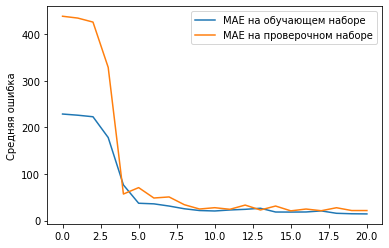

In [42]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [43]:
pred = model_2.predict(dataset_train).flatten()
pred_val = model_2.predict(dataset_val).flatten()

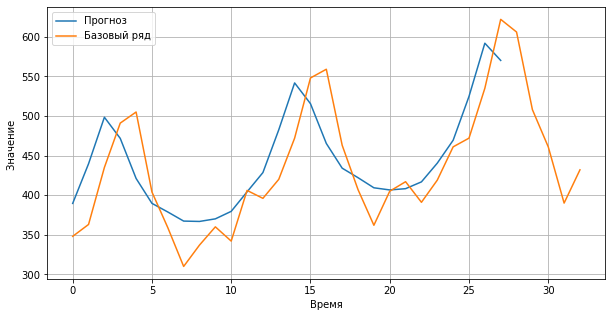

In [44]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

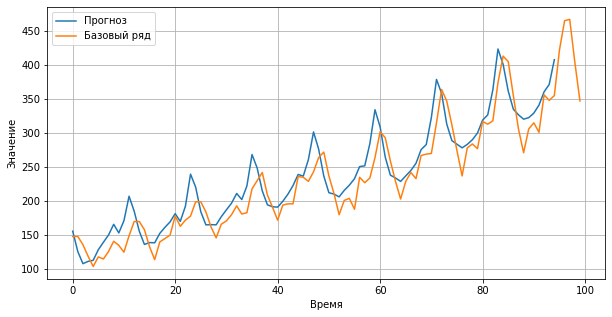

In [45]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [48]:
#датафрейм с метриками
RNN_result = RNN_result.append({'Model': 'LSTM', 
                                'Train mae': history_2.history['mae'][-6], 
                                'Test mae': history_2.history['val_mae'][-6]},
                                 ignore_index=True)

RNN_result.sort_values(by='Test mae')

,Model,Train mae,Test mae
1,LSTM,18.142698,20.773455
0,RNN,36.032673,43.343803


## 4. Построение модели Gated Recurrent Unit (GRU)<a id='section_4'></a>

In [49]:
tf.random.set_seed(8)

model_3 = Sequential()
model_3.add(GRU(524, 
                input_shape=(inputs.shape[1], inputs.shape[2]),
                return_sequences=True))

#сверточный слой
model_3.add(Conv1D(256, 3, activation='linear'))

model_3.add(Flatten())

#полносвязный слой
#model_3.add(Dense(128, activation='linear'))
model_3.add(Dense(64, activation='linear'))
model_3.add(Dense(32, activation='linear'))
model_3.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001) 

model_3.compile(loss='mse', optimizer=opt, metrics=['mae'])

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 524)            836304    
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 256)            402688    
                                                                 
 flatten_7 (Flatten)         (None, 768)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                49216     
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,290,321
Trainable params: 1,290,321
No

In [50]:
%%time

history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                        verbose=1,
                    callbacks=[early_stop]
                   )

#метрики модели
test_loss, test_metric = model_3.evaluate(dataset_val)
print(f"Test loss {test_loss}, Test mae {test_metric}")

Epoch 1/100
10/10 [==============================] - 2s 74ms/step - loss: 60286.4414 - mae: 231.5947 - val_loss: 207053.6250 - val_mae: 447.6530
Epoch 2/100
10/10 [==============================] - 0s 36ms/step - loss: 56002.3789 - mae: 222.8421 - val_loss: 198005.2656 - val_mae: 437.6264
Epoch 3/100
10/10 [==============================] - 0s 38ms/step - loss: 52674.6133 - mae: 217.4764 - val_loss: 188334.4844 - val_mae: 426.2485
Epoch 4/100
10/10 [==============================] - 0s 42ms/step - loss: 4171.0503 - mae: 54.5717 - val_loss: 47668.8867 - val_mae: 205.2381
Epoch 5/100
10/10 [==============================] - 0s 42ms/step - loss: 79263.3906 - mae: 228.9247 - val_loss: 159430.9844 - val_mae: 392.0974
Epoch 6/100
10/10 [==============================] - 0s 41ms/step - loss: 40292.9414 - mae: 187.8869 - val_loss: 154448.0938 - val_mae: 385.6164
Epoch 7/100
10/10 [==============================] - 0s 40ms/step - loss: 28074.0801 - mae: 159.8495 - val_loss: 88981.8125 - val_mae

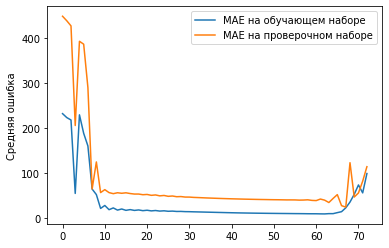

In [51]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [52]:
pred = model_3.predict(dataset_train).flatten()
pred_val = model_3.predict(dataset_val).flatten()

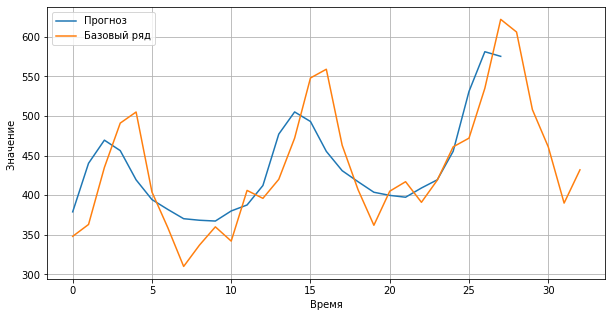

In [53]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

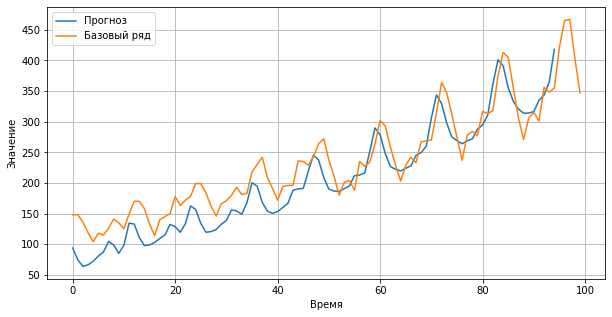

In [54]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [55]:
#датафрейм с метриками
RNN_result = RNN_result.append({'Model': 'GRU', 
                                'Train mae': history_3.history['mae'][-6], 
                                'Test mae': history_3.history['val_mae'][-6]},
                                 ignore_index=True)

RNN_result.sort_values(by='Test mae')

,Model,Train mae,Test mae
1,LSTM,18.142698,20.773455
2,GRU,22.594210,24.215824
0,RNN,36.032673,43.343803


## 5. Сводная таблица метрик и выводы<a id='section_5'></a>

Сводная таблица метрик моделей RNN, LSTM, GRU

In [523]:
RNN_result.sort_values(by='Test mae')

,Model,Train mae,Test mae
0,LSTM,18.855904,20.773577
2,GRU,22.594210,24.215824
1,RNN,36.032673,43.343803


На основе анализа результатов обучения моделей SimpleRNN, LSTM и GRU (с одинаковой подготовкой данных и полносвязными слоями), можно сформулировать следующие **выводы:**
1. Худшую метрику mae показала модель RNN, у нее же отмечается переобучение.
2. Лучшую метрику mae показала модель LSTM. Эта модель обучалась быстрее всех указанных моделей.
3. Mодель GRU имеет наибольшую скорость обучения из всех представленных моделей.
4. Метрику mae на тесте улучшает:
    - увеличение числа нейронов (немонотонно),
    - добавление новых полносвязных слоев,
    - увеличение числа эпох.
5. Метрику mae на тесте ухудшает:
    - добавление более одного рекуррентного слоя,
    - увеличение/уменьшение скорости обучения (оптимальное значение 0.001),
    - увеличение длины истории (не монотонно),
    - увеличение batch_size,
    - смена дефолтных функций активации в рекуррентных слоях. 